In [1]:
%load_ext autoreload
import backtrader as bt
import numpy as np
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

plt.rcParams['figure.figsize'] = (20,10)

In [2]:
import pandas as pd

apple_data = pd.read_csv('/home/ubuntu/apple.csv')
apple_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2017-02-24,135.910004,136.660004,135.279999,136.660004,21690900,136.660004
1,2017-02-23,137.380005,137.479996,136.300003,136.529999,20704100,136.529999
2,2017-02-22,136.429993,137.119995,136.110001,137.110001,20745300,137.110001
3,2017-02-21,136.229996,136.750000,135.979996,136.699997,24265100,136.699997
4,2017-02-17,135.100006,135.830002,135.100006,135.720001,22084500,135.720001


In [3]:
n_window = 10

In [4]:
import math
def make_training_samples(data, window_size):
    N = len(data)
    
    
    n_windows = math.floor(len(data) / window_size)    
    print('Can make %s windows with window size %s' % (n_windows, window_size))
    
    samples = []
    answers = np.empty((1,0))
    for offset in range(window_size):
    
        begin_window = offset
        end_window = begin_window + window_size
        
        for w in range(n_windows):     
            if end_window + 1 < N:

                indices = np.arange(begin_window, end_window)
                examp = data['Close'][indices].as_matrix()
                samples.append(examp)
                
                answers = np.append(answers, data.iloc[end_window + 1]['Close'])

            begin_window += window_size
            end_window += window_size
            
            
        
    return np.stack(samples), answers

In [5]:
samples, answers = make_training_samples(apple_data, 10)

from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(samples, answers)

Can make 27 windows with window size 10


In [6]:
samp = np.linspace(100, 110.0, 10)
clf.predict(samp)

/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 112.040001])

In [22]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        #print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            #if order.isbuy():
                #self.log('BUY EXECUTED, %.2f' % order.executed.price)
            #elif order.issell():
                #self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        #if not self.position:

        window = 10
            
            # Not yet ... we MIGHT BUY if ...
        if len(self.data.get(size=window)) >= window:
            if clf.predict(self.data.get(size=window)) / self.dataclose[0] > 1.03:
                self.order = self.buy()

            if clf.predict(self.data.get(size=window)) / self.dataclose[0] < 0.97:
                #self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


Starting Portfolio Value: 10000.00


/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ubuntu/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprec

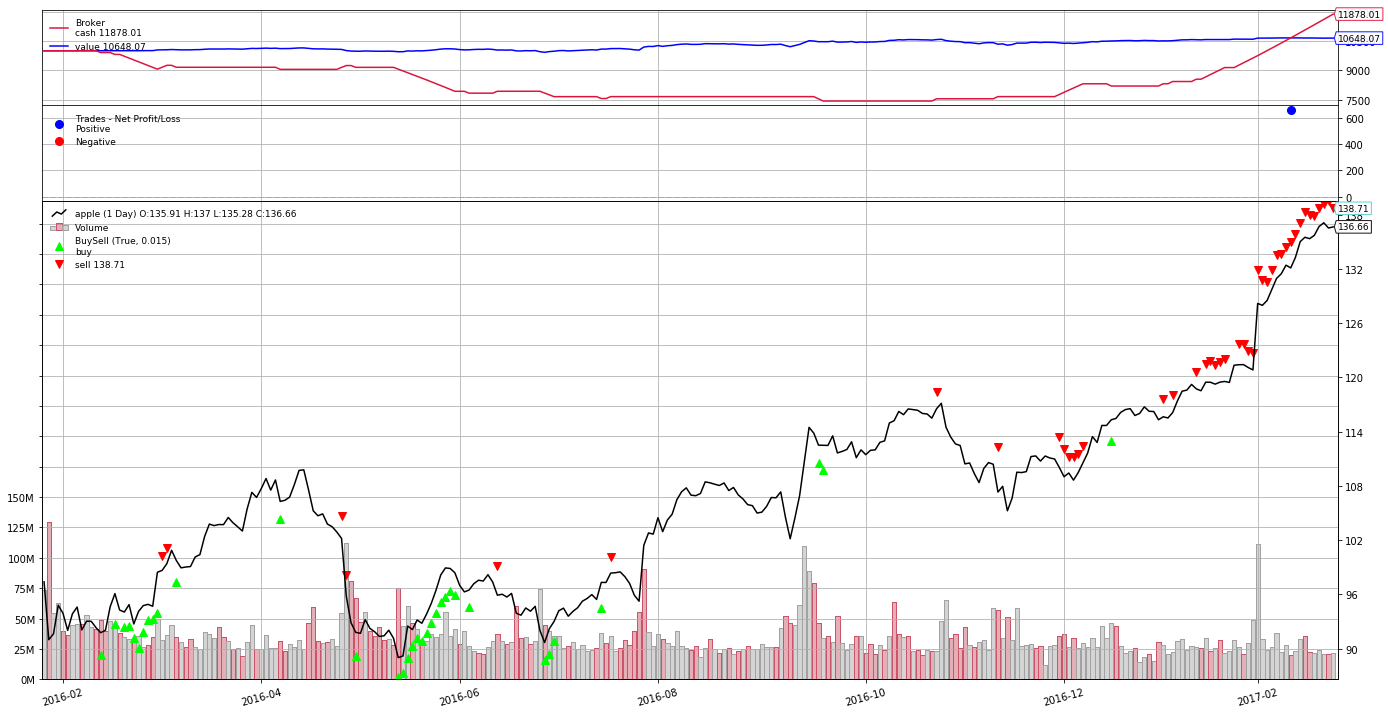

Final Portfolio Value: 10648.07


In [23]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    cerebro.addstrategy(TestStrategy)
    
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '/home/ubuntu/apple.csv')
    
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values after this date
    todate=datetime.datetime(2017, 12, 31),
    reverse=True)
    
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    
    cerebro.broker.setcash(10000.0)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()
    fig = plt.figure(figsize=(20,10))
    cerebro.plot()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())